In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Random walk with normal likelihood, $t$ prior

Recall the model from the last segment of Lesson 2 where the data are the percent change in total personnel from last year to this year for $n=10$ companies. We used a normal likelihood with known variance and $t$ distribution for the prior on the unknown mean. Suppose the values are $y=(1.2,1.4,−0.5,0.3,0.9,2.3,1.0,0.1,1.3,1.9)$. Because this model is not conjugate, the posterior distribution is not in a standard form that we can easily sample. To obtain posterior samples, we will set up a Markov chain whose stationary distribution is this posterior distribution.

$y_i | \mu \stackrel{iid}{\sim} \mathcal(\mu, 1) \text{ }i = 1, ..., n $

$ \mu \sim t(0, 1, 1) $

Recall that the posterior distribution is:

$ p(\mu \mid y_1, \ldots, y_n) \propto \frac{\exp[ n ( \bar{y} \mu - \mu^2/2)]}{1 + \mu^2} $

The posterior distribution on the left is our target distribution and the expression on the right is our $g(μ)$

Because posterior distributions include likelihoods (the product of many numbers that are potentially small), $g(μ)$ might evaluate to such a small number that to the computer, it effectively zero. This will cause a problem when we evaluate the acceptance ratio $α$. To avoid this problem, we can work on the log scale, which will be more numerically stable. Thus, we will write a function to evaluate

$ \log(g(\mu)) = n ( \bar{y} \mu - \mu^2/2) - \log(1 + \mu^2) $

Let's first write the log function.

In [2]:
# Log function proportional to the posterior
def log_function(mu, n, y_bar):
    mu2 = mu**2
    return n * (y_bar * mu - mu2 / 2.0) - np.log(1 + mu2)

Random-Walk Metropolis-Hastings sampler with normal proposals.

In [3]:
from scipy.stats import norm
from scipy.stats import uniform

def random_walk_sampler(n, y_bar, n_iter, mu_init, cand_sd):
    ## Random-Walk Metropolis-Hastings algorithm

    ## Step 1, initialize
    mu_out = [] # Output vector
    accpt = 0 # Number of samples accepted
    mu_now = mu_init # Initial state
    lg_now = log_function(mu = mu_now, n = n, y_bar = y_bar) # Current function value

    ## Step 2, iterate
    for i in range(n_iter):
        ## Step 2a
        mu_cand = norm.rvs(size=1, loc = mu_now, scale = cand_sd)[0] # draw a candidate

        ## Step 2b
        lg_cand = log_function(mu = mu_cand, n = n, y_bar = y_bar) # evaluate log of g with the candidate
        lalpha = lg_cand - lg_now # log of acceptance ratio
        alpha = np.exp(lalpha)

        ## Step 2c
        u = uniform.rvs(size = 1)[0] # draw a uniform variable which will be less than alpha with probability min(1, alpha)
        if (u < alpha): # then accept the candidate
            mu_now = mu_cand
            accpt = accpt + 1 # to keep track of acceptance
            lg_now = lg_cand

        ## collect results
        mu_out.append(mu_now) # save this iteration's value of mu

    return mu_out, accpt / n_iter

Setting the problem

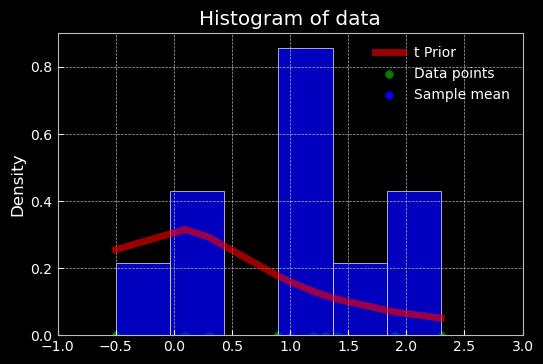

In [4]:
from scipy.stats import t

y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9]) # Data
y_bar = np.mean(y) # Sample mean
n = y.shape[0] # Data points

# Plotting the histogram of the random samples
fig, ax = plt.subplots(1, 1)
sns.histplot(np.array(y), stat= 'density', bins = 6)
# Sampling in all the domain of the function
x = np.linspace(t.ppf(q = 0.01, df = 1),t.ppf(q = 0.99, df = 1), 100)
ax.plot(np.sort(y), t.pdf(x = np.sort(y), df = 1), 'r-', lw=5, alpha=0.6, label='t Prior') # prior for mu 
ax.scatter(y, np.repeat(0, n), s = 30, c='green', label = 'Data points') # individual data points
ax.scatter(y_bar, 0, s = 30, c='blue', label = 'Sample mean') # sample mean
ax.legend(loc='best', frameon=False)
plt.xlim(-1, 3)  
plt.title('Histogram of data')
plt.show()

Run the sampler! Let’s use $m=1000$ iterations and proposal standard deviation (which controls the proposal step size) $3.0$, and initial value at the prior median $0$.

In [5]:
np.random.seed(43) # set the random seed for reproducibility
it = int(1e3)
samples, aceptance = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 0.0, cand_sd = 3.0)
print('The mean of the sampled distribution is: {}'.format(samples[:5]))
print('The percentage of acceptance were: {}'.format(aceptance))

The mean of the sampled distribution is: [0.7721997760340801, 0.7721997760340801, 0.7721997760340801, 0.7721997760340801, 0.7721997760340801]
The percentage of acceptance were: 0.116


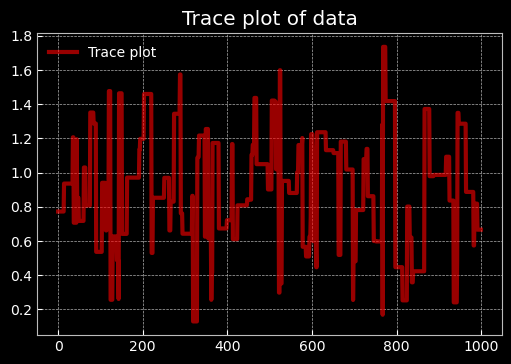

In [6]:
# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(it), samples, 'r-', lw=3, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
plt.title('Trace plot of data')
plt.show()

It shows the history of the chain and provides basic feedback about whether the chain has reached its stationary distribution.

It appears our proposal step size was too large (acceptance rate below $23%$). Let’s try another.

The mean of the sampled distribution is: [-0.07101312199363279, -0.13150806068918167, -0.16500276457357058, -0.16500276457357058, -0.13909634862464015]
The percentage of acceptance were: 0.942


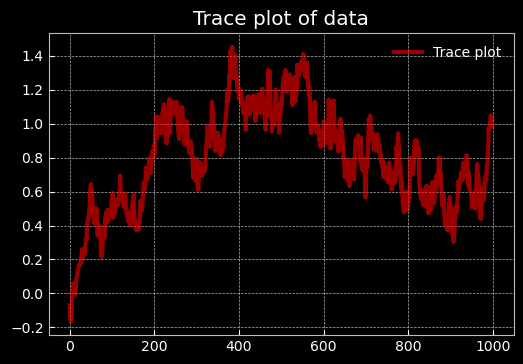

In [7]:
samples, aceptance = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 0.0, cand_sd = 0.05)
print('The mean of the sampled distribution is: {}'.format(samples[:5]))
print('The percentage of acceptance were: {}'.format(aceptance))

# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(it), samples, 'r-', lw=3, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
plt.title('Trace plot of data')
plt.show()

The acceptance rate is too high (above $50%$). Let’s try something in between.

The mean of the sampled distribution is: [1.406512956468385, 1.406512956468385, 1.3038891874131793, 1.1006790708210246, 0.7058252960154938]
The percentage of acceptance were: 0.371


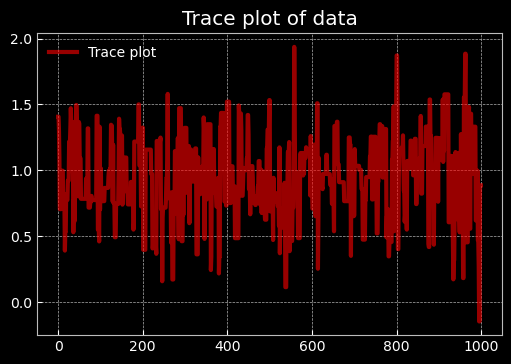

In [8]:
samples, aceptance = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 0.0, cand_sd = 0.9)
print('The mean of the sampled distribution is: {}'.format(samples[:5]))
print('The percentage of acceptance were: {}'.format(aceptance))

# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(it), samples, 'r-', lw=3, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
plt.title('Trace plot of data')
plt.show()

The last one looks good!  let’s see what happens if we initialize the chain at some far-off value.

The mean of the sampled distribution is: [29.73708290294415, 29.73708290294415, 29.73708290294415, 29.73708290294415, 28.98467782856045]
The percentage of acceptance were: 0.398


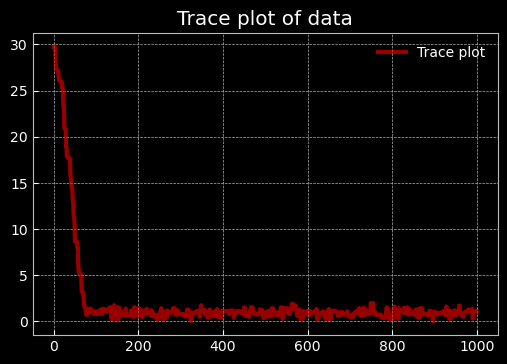

In [9]:
samples, aceptance = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 30.0, cand_sd = 0.9)
print('The mean of the sampled distribution is: {}'.format(samples[:5]))
print('The percentage of acceptance were: {}'.format(aceptance))

# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(it), samples, 'r-', lw=3, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
plt.title('Trace plot of data')
plt.show()

It took awhile to find the stationary distribution, but it looks like we succeeded! If we discard the first $100$ or so values, it appears like the rest of the samples come from the stationary distribution, our posterior distribution! Let’s plot the posterior density against the prior to see how the data updated our belief about $μ$.

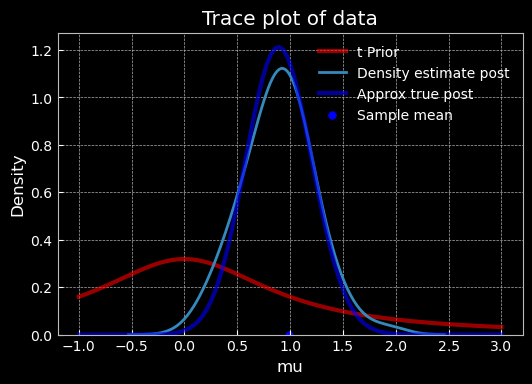

In [10]:
samples_discard = samples[200:] # Discard the first 200 samples

# Plotting the posterior density
fig, ax = plt.subplots(1, 1)
# Sampling in all the domain of the function
x = np.linspace(-1 , 3, 100)
ax.plot(x, t.pdf(x = x, df = 1), 'r-', lw = 3, alpha=0.6, label='t Prior') # prior for mu 
ax.scatter(y_bar, 0, s = 30, c='blue', label = 'Sample mean') # Sample mean
# plot density estimate of the posterior
sns.kdeplot(np.array(samples_discard), bw=0.5, label = 'Density estimate post')
# Approximation true posterior
ax.plot(x, 0.017*np.exp(log_function(mu = x, n = n, y_bar = y_bar)), 'b-', lw = 3, alpha=0.6, label='Approx true post')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('mu')
plt.title('Trace plot of data')
plt.show()

Obtaining posterior samples using the Metropolis-Hastings algorithm can be time-consuming and require some fine-tuning, as we’ve just seen. The good news is that we can rely on software to do most of the work for us.